<h1> 1. Business Problem </h1>

<h2> 1.1 Description </h2>

<p>Quora is a place to gain and share knowledge—about anything. It’s a platform to ask questions and connect with people who contribute unique insights and quality answers. This empowers people to learn from each other and to better understand the world.</p>
<p>
Over 100 million people visit Quora every month, so it's no surprise that many people ask similarly worded questions. Multiple questions with the same intent can cause seekers to spend more time finding the best answer to their question, and make writers feel they need to answer multiple versions of the same question. Quora values canonical questions because they provide a better experience to active seekers and writers, and offer more value to both of these groups in the long term.
</p>
<br>
> Credits: Kaggle 


__ Problem Statement __
- Identify which questions asked on Quora are duplicates of questions that have already been asked. 
- This could be useful to instantly provide answers to questions that have already been answered. 
- We are tasked with predicting whether a pair of questions are duplicates or not. 

<h2>1.3 Real world/Business Objectives and Constraints </h2>

1. The cost of a mis-classification can be very high.
2. You would want a probability of a pair of questions to be duplicates so that you can choose any threshold of choice.
3. No strict latency concerns.
4. Interpretability is partially important.

<h1> 2. Mapping to : Machine learning Problem </h1>

* Types of ML Problem : Binary Classification
* Performance Metric KPI : Log Loss (As we are dealing with probabilites) and Confusion Matrix for further evaluation


<h1> 3. Exploratory Data Analysis </h1>

In [1]:
# Importing the library
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from subprocess import check_output
%matplotlib inline
import plotly.offline as py
py.init_notebook_mode(connected=True)
import plotly.graph_objs as go
import plotly.tools as tls
import os
import gc

import re
from nltk.corpus import stopwords
import distance
from nltk.stem import PorterStemmer
from bs4 import BeautifulSoup

In [2]:
# reading the dataset
df = pd.read_csv("train.csv")

In [3]:
df.head()

,id,qid1,qid2,question1,question2,is_duplicate
0,0,1,2,What is the step by step guide to invest in sh...,What is the step by step guide to invest in sh...,0
1,1,3,4,What is the story of Kohinoor (Koh-i-Noor) Dia...,What would happen if the Indian government sto...,0
2,2,5,6,How can I increase the speed of my internet co...,How can Internet speed be increased by hacking...,0
3,3,7,8,Why am I mentally very lonely? How can I solve...,Find the remainder when [math]23^{24}[/math] i...,0
4,4,9,10,"Which one dissolve in water quikly sugar, salt...",Which fish would survive in salt water?,0


In [4]:
# checking the dataframe info
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 404290 entries, 0 to 404289
Data columns (total 6 columns):
id              404290 non-null int64
qid1            404290 non-null int64
qid2            404290 non-null int64
question1       404289 non-null object
question2       404288 non-null object
is_duplicate    404290 non-null int64
dtypes: int64(4), object(2)
memory usage: 18.5+ MB


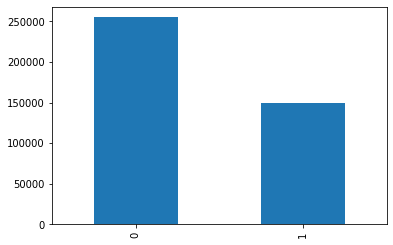

In [9]:
# checking the distribution of class variables
# but every (qid1,qid2) can be unique combinations
df.is_duplicate.value_counts().plot.bar()

In [5]:
# total number of question for pairs
print("There are {} numbers of data points for training ".format(df.shape[0]))

There are 404290 numbers of data points for training 


In [6]:
# How many question pairs are similars 
print("{}% of questions are similar".format(round(df.is_duplicate.value_counts()[0]/df.shape[0]*100,2)))

print("{}% of questions are not similar".format(100 - round(df.is_duplicate.value_counts()[0]/df.shape[0]*100,2)))

63.08% of questions are similar
36.92% of questions are not similar


In [31]:
qids = pd.Series(df['qid1'].tolist()+df['qid2'].tolist())

In [53]:
print("There are {} numbers of unique combinations and {}% are more than once ".format(len(np.unique(qids)),\
                                                                                       round(np.sum(qids.value_counts()>1)/len(np.unique(qids))*100,2)))


print("Question having max number of count",max(qids.value_counts()))

There are 537933 numbers of unique combinations and 20.78% are more than once 
Question having max number of count 157


In [57]:
df.head()

,id,qid1,qid2,question1,question2,is_duplicate
0,0,1,2,What is the step by step guide to invest in sh...,What is the step by step guide to invest in sh...,0
1,1,3,4,What is the story of Kohinoor (Koh-i-Noor) Dia...,What would happen if the Indian government sto...,0
2,2,5,6,How can I increase the speed of my internet co...,How can Internet speed be increased by hacking...,0
3,3,7,8,Why am I mentally very lonely? How can I solve...,Find the remainder when [math]23^{24}[/math] i...,0
4,4,9,10,"Which one dissolve in water quikly sugar, salt...",Which fish would survive in salt water?,0


In [66]:
# checking for duplicates or if there are repeated pair of questions
df[["qid1","qid2","is_duplicate"]].groupby(["qid1","qid2"]).filter(lambda x:len(x)>1).shape

(0, 3)

In [93]:
# checking for different type of duplicates as 1,2 and 2,1 can both be same. So we will do self join inverted 
# and it joins results something then duplicates exists
pd.merge(df[["qid1","qid2","is_duplicate"]],df[["qid2","qid1"]],left_on=['qid1','qid2'],right_on=['qid2','qid1']).shape[0]



0

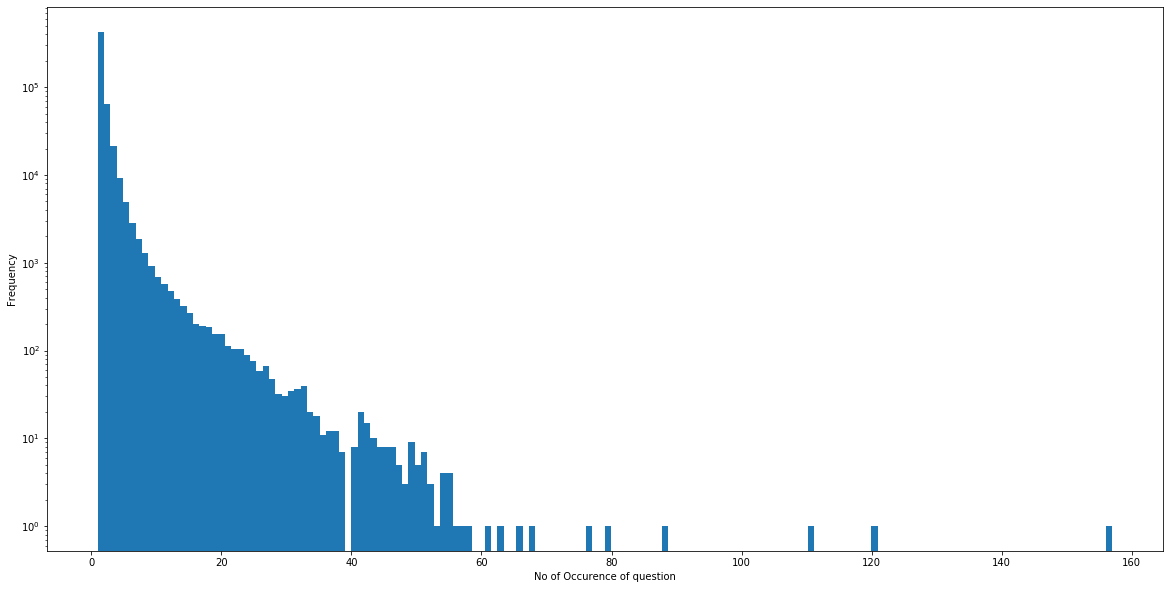

In [68]:
plt.figure(figsize=(20,10))
plt.hist(qids.value_counts(),bins=160)
plt.yscale('log',nonposy='clip')
plt.xlabel('No of Occurence of question')
plt.ylabel('Frequency')
plt.show()

In [71]:
# checking for Nan Values
df[df.isnull().any(1)]

,id,qid1,qid2,question1,question2,is_duplicate
105780,105780,174363,174364,How can I develop android app?,NaN,0
201841,201841,303951,174364,How can I create an Android app?,NaN,0
363362,363362,493340,493341,NaN,My Chinese name is Haichao Yu. What English na...,0


In [73]:
df = df.fillna('')
# checking for Nan Values
df[df.isnull().any(1)]

,id,qid1,qid2,question1,question2,is_duplicate


<h2>3.3 Basic Feature Extraction (before cleaning) </h2>


Let us now construct a few features like:
 - ____freq_qid1____ = Frequency of qid1's
 - ____freq_qid2____ = Frequency of qid2's 
 - ____q1len____ = Length of q1
 - ____q2len____ = Length of q2
 - ____q1_n_words____ = Number of words in Question 1
 - ____q2_n_words____ = Number of words in Question 2
 - ____word_Common____ = (Number of common unique words in Question 1 and Question 2)
 - ____word_Total____ =(Total num of words in Question 1 + Total num of words in Question 2)
 - ____word_share____ = (word_common)/(word_Total)
 - ____freq_q1+freq_q2____ = sum total of frequency of qid1 and qid2 
 - ____freq_q1-freq_q2____ = absolute difference of frequency of qid1 and qid2 

In [151]:
x = '120000011'
re.sub(r"([0-9]+)......([0-9])", r"\1m", x)

'12m'